In [1]:
# import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
from functools import reduce
import string
import operator
from operator import itemgetter 
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
from tensorflow.keras.models import model_from_json
np.random.seed(100)
import random


market = [ "AD", "AR", "AT", "AU", "BE", "BG", "BO", "BR", "CA", "CH", "CL", "CO", "CR", "CY", 
      "CZ", "DE", "DK", "DO", "EC", "EE", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HU", 
      "ID", "IE", "IS", "IT", "JP", "LI", "LT", "LU", "LV", "MC", "MT", "MX", "MY", "NI", "NL", 
      "NO", "NZ", "PA", "PE", "PH", "PL", "PT", "PY", "SE", "SG", "SK", "SV", "TH", "TR", "TW", 
      "US", "UY", "VN" ]

CLIENT_ID = "bccb28dd24804ecc912efc88806eba38"
CLIENT_SECRET = "e795231413554786934e6a6209106e8d"

credentials = oauth2.SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

## Spotify Million Playlist Dataset- Initial EDA from Milestone 3

We read in 100 of the 1000 playlists, each with around 65000 songs, and performed some initial EDA. We first look at the number of songs per playlist for the 100 playlists. We then analyze the distribution of song durations, by playlist, both as a series of boxplots and as overlayed histograms. We then look at the distributions of overall repetitions of songs, artists, and albums in the combined playlists dataframe. We also look at the distribution of number of songs per album. Finally, we viewed the top 100 artists and top 100 albums, selected by overall frequency in the combined playlists.

The most interesting thing we noticed about the dataset through initial EDA was each playlist was extremely long, leading us to wonder whether these playlists were made by individuals or not. Through EDA it seems that song duration isn't particularly important, so it seems the main way in which this dataset will be useful to us is through its grouping of songs into playlist, which hopefully indicates that the songs that are in one playlist are all liked by people who share that particular taste in music

In [2]:
with open('playlists.pickle', 'rb') as f:
    playlists = pickle.load(f)

In [3]:
# merge playlists
all_songs = pd.DataFrame()
for i, pl in enumerate(playlists):
    pl['playlist_id'] = i
all_songs = pd.concat(playlists)

In [4]:
all_songs.columns

Index(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name', 'playlist_id'], dtype='object')

In [5]:
# distribution of number of repetitions per song
all_songs['track_name'].value_counts().describe()

count    484279.000000
mean         13.789159
std          88.013276
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        6844.000000
Name: track_name, dtype: float64

In [6]:
# distribution of number of repetitions per song
all_songs['artist_name'].value_counts().describe()

count    108091.000000
mean         61.779427
std         632.511007
min           1.000000
25%           1.000000
50%           2.000000
75%           9.000000
max       82460.000000
Name: artist_name, dtype: float64

In [7]:
# distribution of number of repetitions per album
all_songs['album_name'].value_counts().describe()

count    218621.000000
mean         30.545099
std         234.269590
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       20342.000000
Name: album_name, dtype: float64

In [8]:
top_10_artists = all_songs['artist_name'].value_counts().nlargest(10)

Text(0, 0.5, 'Artist Name')

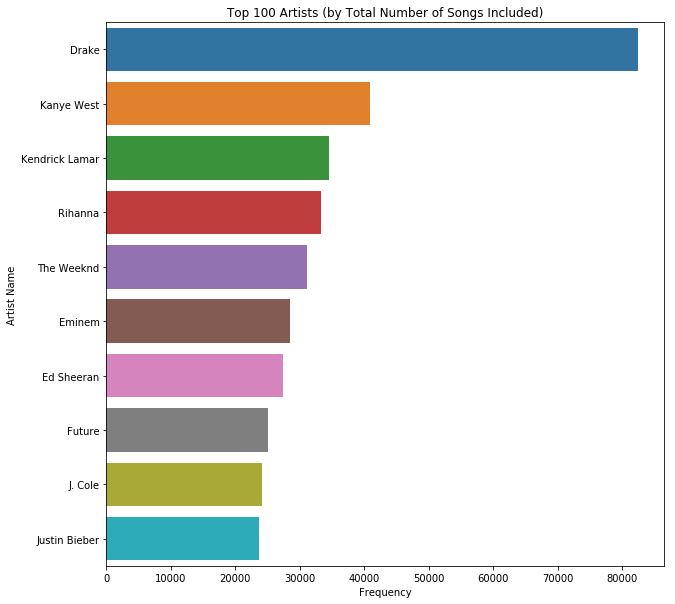

In [9]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=top_10_artists, y=top_10_artists.index)
ax.set_title('Top 100 Artists (by Total Number of Songs Included)')
ax.set_xlabel("Frequency")
ax.set_ylabel('Artist Name')


## Spotify API
The Spotify API offers a lot of information that we could potentially use, and we decided to explore its functionality by looking at visual representations of some of the attributes of songs that we thought might be most important for predicting music taste, on a random sample of 30 songs.

In [10]:
#randomly collect 10 song uris for analysis
random_seed = 109
np.random.seed(random_seed)
sample_songs = all_songs.sample(n = 10)
rand_ids = [track[14:] for track in sample_songs.track_uri]
rand_ids

['5KY7zgFeH2GWoL1zP9mME6',
 '5wQnmLuC1W7ATsArWACrgW',
 '5sdYtv8t8dWGCPaSqYJkY4',
 '2bjwRfXMk4uRgOD9IBYl9h',
 '1HCw8XKtTgWWU3JlEUR0qQ',
 '0d28khcov6AiegSCpG5TuT',
 '6VixoRqnikN4QqegoKUSbH',
 '5rgrBsAFYMun6yhtnLKRPz',
 '7vtuYSHkY01YTT5djvKQZw',
 '30ST8wGrUm3puztIO4wFV2']

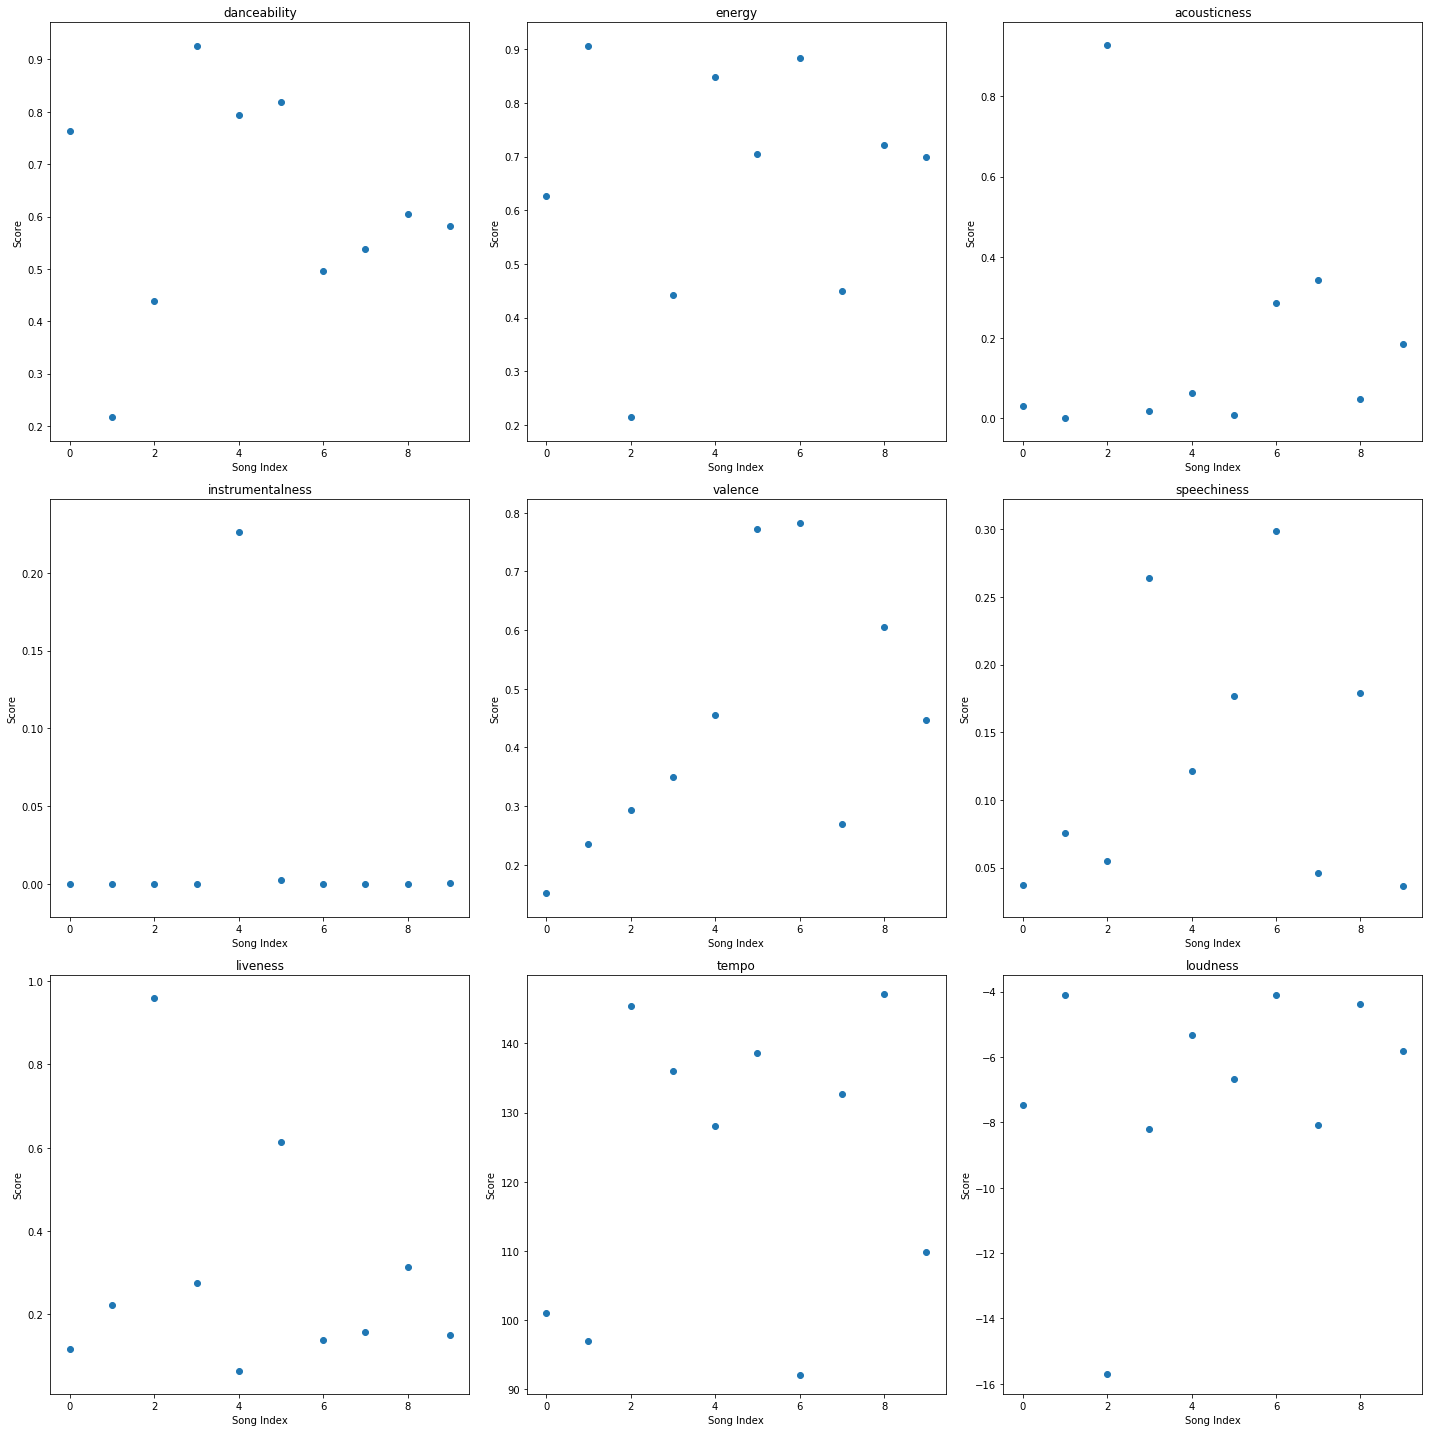

In [11]:
random_seed = 109
np.random.seed(random_seed)
sample_songs = all_songs.sample(n = 10)
rand_ids = [track[14:] for track in sample_songs.track_uri]

# plot of 10 randomly chosen songs' features
info = spotify.audio_features(rand_ids)
features = ["danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
fig, axs = plt.subplots(3,3, figsize = (20,20))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(np.arange(0, 10), [track[features[i]] for track in info])
    ax.set_title(features[i])
    ax.set_xlabel("Song Index")
    ax.set_ylabel('Score')
fig.tight_layout()


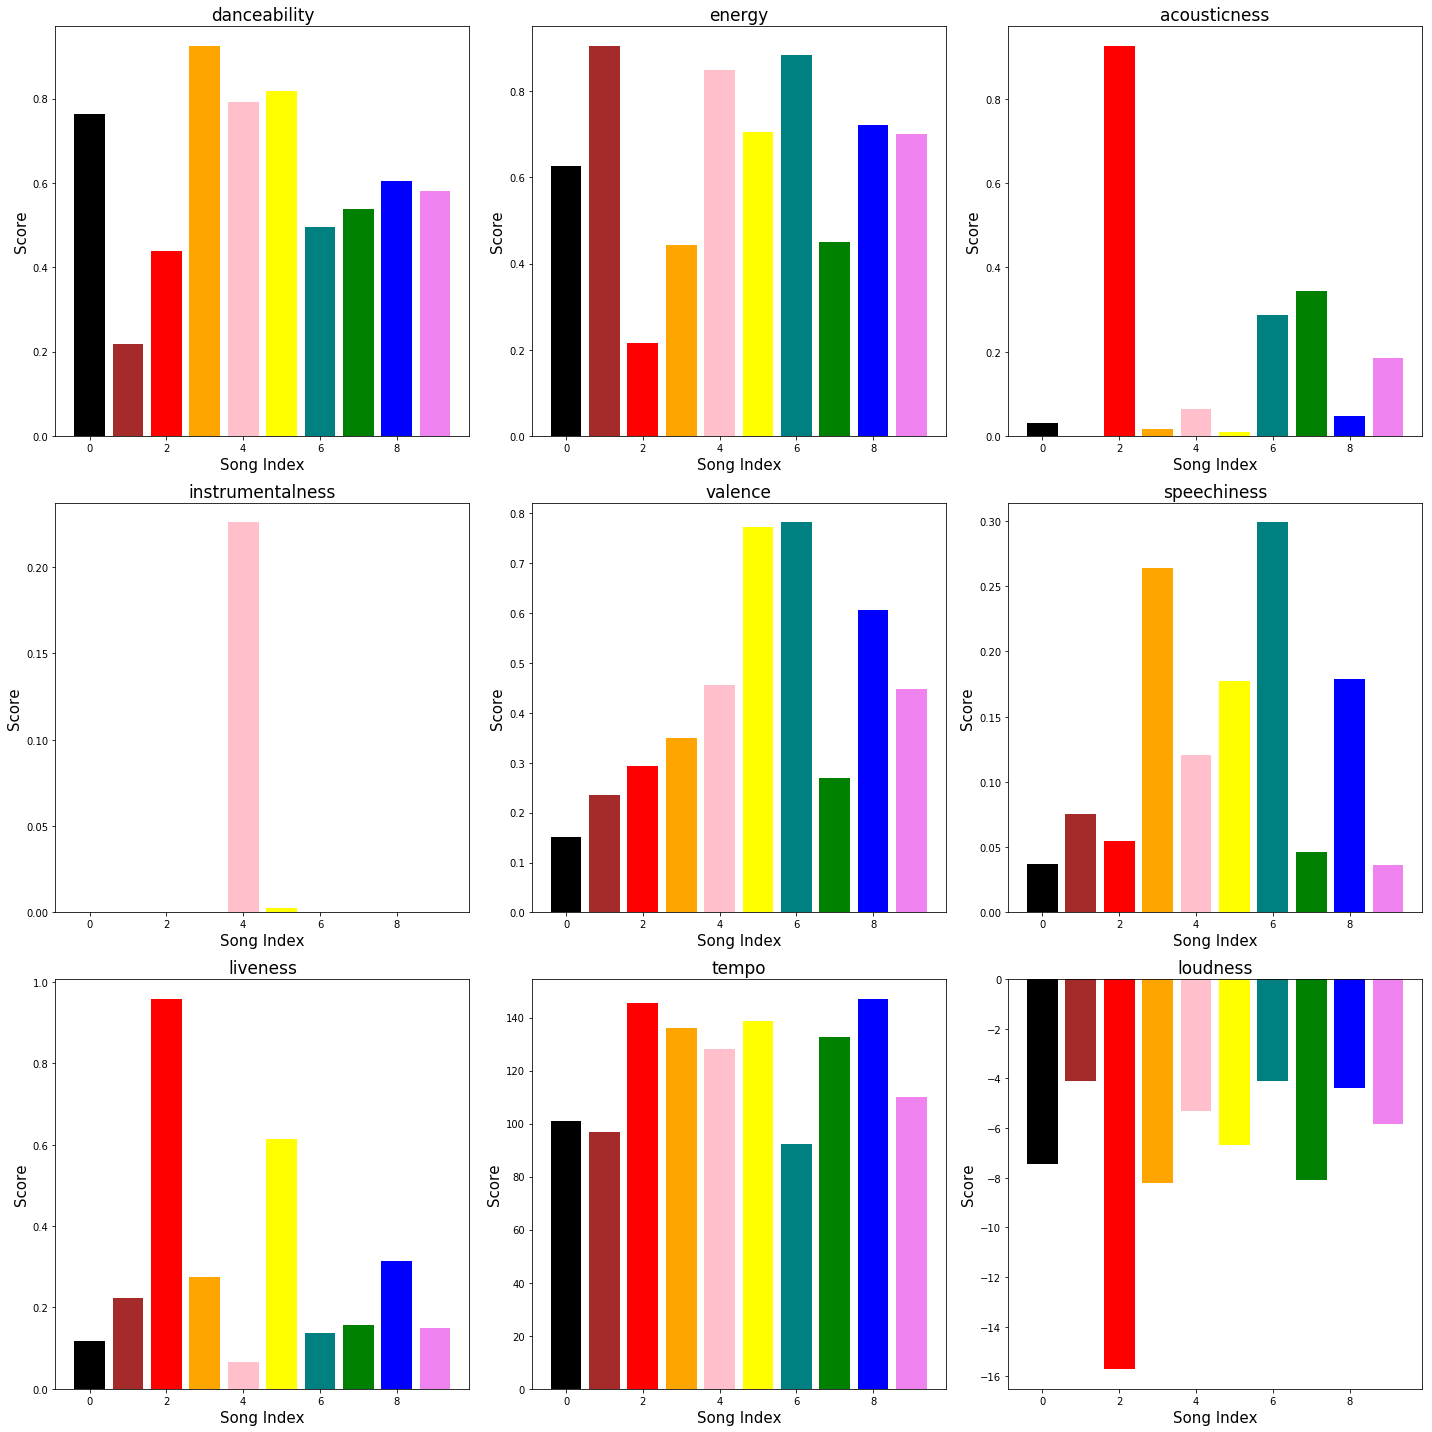

In [12]:
#make the plots easier to read
fig, axs = plt.subplots(3,3, figsize = (20,20))
for i, ax in enumerate(axs.ravel()):
    ax.bar(np.arange(0, 10), [track[features[i]] for track in info],
           color=['black','brown', 'red', 'orange', 'pink','yellow', 'teal','green', 'blue', 'violet'])
    ax.set_title(features[i], fontsize = 17)
    ax.set_xlabel("Song Index", fontsize = 15)
    ax.set_ylabel('Score', fontsize = 15)
  
fig.tight_layout()
plt.savefig('barplot_song_score.png')

There didn't seem to any striking correlations between any of the attributes, but we suspect that audio features such as speechiness and acousticness may have some colinearity, so when we create our final model we will likely use some form of Lasso-liek regularization to pare down the features we use as our predictors.

## Initial Model
Given the sources we have, it seems the most interesting question we could investigate is the automatic playlist generation problem, or song radio creation--given a single song (or a whole playlist), generate proposed songs that the user might like. So, for our initial model, we decided to use the Million Playlist Dataset in conjunction with the Spotify API to generate a "next up on the radio" song given an input song from the user. Again, we didn't see a way to incorporate the song lyrics, so we left them out.

In the initial base model below, we take an input song via its URI, and select all playlists that contain the given song. Then, we find the intersection of the songs in the selected playlists, and remove from this intersection the set of songs in all the playlists, as we want to exclude songs that are so popular that they do not give us much information about specific music taste. This operates on the assumption that if a person likes a particular song, they may also like the music liked by other people who like that song. Essentially, we find other people who also like that song, find the songs that all of them like, excluding extremely popular songs, which will be our list of potential songs. 

Then, we use the Spotify API to get the audio features of these potential songs. Based purely on gut instinct, we decided that the most relevant audio features were: danceability, energy, acousticness, instrumentalness, and valence. For our final model, we would use cross-validation to select the most relevant predictors. We then used the sum of the squared difference of those audio features between the input song and the potential songs to assign each potential song a score, and then output the song with the lowest score (most similar to the input song).  

In [13]:
def find_playlists_with_song(song):
    return all_songs.loc[all_songs['track_name'] == song].playlist_id.unique() 
def find_common_songs(playlists):
    return reduce(set.intersection, [set(pl.track_name.unique()) for pl in playlists ])
basic = find_common_songs(playlists)

In [14]:
uris_sorted = []
def base_model(track_uri, n):
    playlist_ids = all_songs.loc[all_songs['track_uri'] == track_uri].playlist_id.unique()
    playlists_with_song = [playlists[pl] for pl in find_playlists_with_song('Ezra')]
    common_songs = reduce(set.intersection, [set(pl.track_uri.unique()) for pl in playlists_with_song ])
    basic = reduce(set.intersection, [set(pl.track_uri.unique()) for pl in playlists ])
    potential = common_songs.difference(basic)
    target = list(potential)[1:n]
    rec_ids = [track[14:] for track in target]
    
    target_info = spotify.audio_features(track_uri[14:])
    tracks_info = spotify.audio_features(rec_ids)
    tracks_scores = dict()
    for i, track in enumerate(tracks_info):
        tracks_scores[str(rec_ids[i])] = (target_info[0]['danceability'] - track['danceability'])**2 + (target_info[0]['energy'] - track['energy'])**2 +(target_info[0]['acousticness'] - track['acousticness'])**2 + (target_info[0]['instrumentalness'] - track['instrumentalness'])**2 + (target_info[0]['valence'] - track['valence'])**2
    sorted_scores = sorted(tracks_scores.items(), key=operator.itemgetter(1))
    list_scores = [item[0] for item in sorted_scores]

    for i in range(0,11):
        uri_of_songs = spotify.track(list_scores[i])['uri']
        uris_sorted.append(uri_of_songs)
    #return sorted_scores[0:10], spotify.track(sorted_scores[0][0])
    return uris_sorted

example = base_model('spotify:track:0zG9M0rfjwe9gwsaQXN071', 30)

In [15]:
unique_song_list = []
for i in example:
    unique_song_list.append(all_songs.track_name.loc[all_songs.track_uri == i].drop_duplicates(
        keep='first').tolist())

In [16]:
unique_song_list

[['Ezra'],
 ["As She's Walking Away (feat. Alan Jackson)"],
 ['100 Years'],
 ['Trndsttr (feat. M. Maggie) - Lucian Remix'],
 ['Every Rose Has Its Thorn - 2003 - Remaster'],
 ['Come On Get Higher'],
 ['Rock Bottom'],
 ['Pound Cake / Paris Morton Music 2'],
 ['Teenage Dirtbag'],
 ['Helluva Life'],
 ['Gangsta']]

## Chosen Model: Neural Network with Embedding

In [17]:
# Million Playlists Dataset
with open('playlists.pickle', 'rb') as f:
    playlists = pickle.load(f)

In [18]:
# create unique ids for each playlist
all_songs = pd.DataFrame()
for i, group in enumerate(playlists):
    group['group_id'] = i
all_songs = pd.concat(playlists)
all_songs
all_songs['pid']
all_songs['group_id']
all_songs['unique_id'] = 1000*all_songs['group_id'] + all_songs['pid']
all_songs['playlist_id'] = all_songs['unique_id']


In [19]:
# drop unused features
just_songs = all_songs[['track_uri', 'playlist_id', 'artist_name']]
just_songs = just_songs.loc[just_songs['playlist_id'] < 10]

In [20]:
# create unique indices for each song so they can be embedded
unique_songs = just_songs['track_uri'].unique()
song_index = {song: idx for idx, song in enumerate(unique_songs)}
index_song = {idx: song for song, idx in song_index.items()}

In [21]:
# create unique indices for each artist so they can be embedded
unique_artists = just_songs['artist_name'].unique()
artist_index = {artist: idx for idx, artist in enumerate(unique_artists)}
index_artist = {idx: artist for artist, idx in artist_index.items()}

In [22]:
just_songs['song_index'] = [song_index[song] for song in just_songs['track_uri']]
just_songs['artist_index'] = [artist_index[artist] for artist in just_songs['artist_name']]
just_songs.head()

,track_uri,playlist_id,artist_name,song_index,artist_index
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0,Missy Elliott,0,0
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,0,Britney Spears,1,1
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0,Beyoncé,2,2
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,0,Justin Timberlake,3,3
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,0,Shaggy,4,4


In [23]:
# find features for each track via spotify API
uris = [track[14:] for track in unique_songs]
# spotify API can only query 100 tracks at once
n = 100
batches = [uris[i * n:(i + 1) * n] for i in range((len(uris) + n - 1) // n )]
infos = []
for batch in batches:
    infos.append(spotify.audio_features(batch))

In [24]:
with open('infos.pickle', 'wb') as f:
    pickle.dump(infos, f)

# for 10 playlists (503 unique songs)
with open('infos.pickle', 'rb') as f:
    infos = pickle.load(f)
infos = [j for i in infos for j in i]


In [25]:
len(infos)

503

In [26]:
# add features to just_songs dataframe
features = ["danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
for feature in features:
    just_songs[feature] = None
for song in unique_songs:
    for track in infos:
        if track['uri'] == song:
            t = track
            song_features = [track[feature] for feature in features]
            break;
    just_songs.loc[just_songs['track_uri'] == song, features] = song_features

In [27]:
with open('just_songs.pickle', 'wb') as f:
    pickle.dump(just_songs, f)

with open('just_songs.pickle', 'rb') as f:
    just_songs = pickle.load(f)

In [28]:
just_songs.columns

Index(['track_uri', 'playlist_id', 'artist_name', 'song_index', 'artist_index', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness', 'liveness', 'tempo', 'loudness'], dtype='object')

In [29]:
unique_song_ids = just_songs['song_index'].unique()
just_songs.shape
unique_song_ids.shape

(503,)

In [30]:
# add all pairs of songs in same playlist as positive examples to train on
predictors = ["artist_index", "danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
pairs = []
for song in unique_song_ids:
    pl = just_songs.loc[just_songs['song_index'] == song]['playlist_id']
    song1_feat = [just_songs[just_songs['song_index'] == song][pred].unique().item() for pred in predictors]
    for p in pl:
        for _, song2 in just_songs.loc[just_songs['playlist_id'] == p].iterrows():
            song2_feat = [song2[pred] for pred in predictors]
            pairs.append(song1_feat + song2_feat)
pairs = np.array(pairs)

In [31]:
#save pairs
with open('pairs.pickle', 'wb') as f:
    pickle.dump(pairs, f)

with open('pairs.pickle', 'rb') as f:
    pairs = pickle.load(f)

In [32]:
pairs_set = set([tuple(i) for i in pairs[:, [0,10]]])

In [33]:
#save pairs_set
with open('pairs_set.pickle', 'wb') as f:
    pickle.dump(pairs_set, f)
with open('pairs_set.pickle', 'rb') as f:
    pairs_set = pickle.load(f)

In [34]:
#create a validation set for our neural network
pairs_train, pairs_val = train_test_split(pairs, test_size=0.2, random_state=109)

In [35]:
print(pairs_train.shape)
print(pairs_val.shape)
print(pairs.shape)

(29206, 20)
(7302, 20)
(36508, 20)


In [36]:
#making plot of most common songs in true song pairs
import collections
a_list = []
for i in range(len(pairs_train)):
    a = pairs_train[i][0]
    a_list.append(a)
counter=collections.Counter(a_list)
counter.items()
list_common = counter.most_common(10)
list_of_vals = [i[1] for i in list_common]
list_of_indices = [i[0] for i in list_common]
values = []
for i in list_of_indices:
    val = just_songs.track_uri.loc[just_songs.song_index == i - 1].tolist()
    values.append(val)

flat_list_vals = [item for sublist in values for item in sublist]

new_val_songs = []
for song in flat_list_vals: 
    new_val_songs.append(all_songs.track_name.loc[all_songs.track_uri == song].drop_duplicates(keep = 'first').tolist())
flat_list_songs = [item for sublist in new_val_songs for item in sublist]
flat_list_songs

['Hold Me Tight',
 'Hola Hola',
 "It's Definitely You",
 'Ring My Bell',
 'Ah-Choo',
 'The Room Where It Happens',
 "Leavin'",
 "It's Your Body 4",
 'Luv',
 'Spring Day']

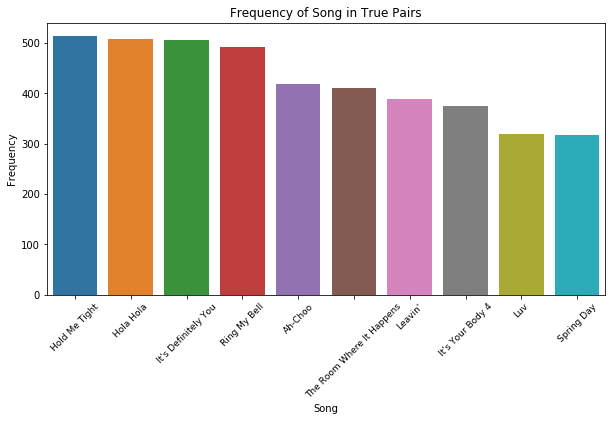

In [37]:
plt.figure(figsize=(10,5))
chart = sns.barplot(x=flat_list_songs, y = list_of_vals);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, fontsize = 9)
chart.set(xlabel='Song', ylabel='Frequency')
plt.title("Frequency of Song in True Pairs")
plt.savefig('barplot_song_freq.png')

In [38]:
# function to generate batches of negative and positive examples to train on
def generate_batch(pairs_train, n_positive = 50, n_negative = 100):
    predictors = ["artist_index", "danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]

    """Generate batches of samples for training"""
    batch_size = n_positive + n_negative
    batch = np.zeros((batch_size, 21))
        
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, pair in zip(range(n_positive), pairs_train[np.random.randint(pairs_train.shape[0], size=n_positive), :]):
            batch[idx, :] = np.append(pair, 1)
        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            song1 = random.randrange(len(unique_song_ids))
            song2 = random.randrange(len(unique_song_ids))
            
            # Check to make sure this is not a positive example
            if (song1, song2) not in pairs_set:
                
                song1_feat = [just_songs[just_songs['song_index'] == song1][pred].unique().item() for pred in predictors]
                song2_feat = [just_songs[just_songs['song_index'] == song2][pred].unique().item() for pred in predictors]
                
                # Add to batch and increment index
                batch[idx, :] = np.concatenate([song1_feat, np.append(song2_feat, 0)])
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        
        d = dict({'song1': batch[:, 0]})
        d.update({feat + '1': batch[:, i+1] for i, feat in enumerate(predictors)})
        d.update({'song2': batch[:, 10]})
        d.update({feat + '2': batch[:, i+10] for i, feat in enumerate(predictors)})

        
        yield  d, batch[:, 20]

In [39]:
next(generate_batch(pairs_train, n_positive = 2, n_negative = 1))

({'song1': array([ 14., 323.,  57.]),
  'artist_index1': array([0.669, 0.586, 0.293]),
  'danceability1': array([0.822, 0.848, 0.787]),
  'energy1': array([0.0339 , 0.038  , 0.00774]),
  'acousticness1': array([1.42e-04, 6.40e-04, 4.96e-01]),
  'instrumentalness1': array([0.43 , 0.645, 0.138]),
  'valence1': array([0.043 , 0.297 , 0.0438]),
  'speechiness1': array([0.231, 0.122, 0.392]),
  'liveness1': array([120.011, 137.723, 165.307]),
  'tempo1': array([-4.288, -6.899, -8.841]),
  'loudness1': array([211.,  71.,  47.]),
  'song2': array([211.,  71.,  47.]),
  'artist_index2': array([211.,  71.,  47.]),
  'danceability2': array([0.621, 0.827, 0.633]),
  'energy2': array([0.616, 0.722, 0.858]),
  'acousticness2': array([0.0765 , 0.00579, 0.208  ]),
  'instrumentalness2': array([0.    , 0.    , 0.0114]),
  'valence2': array([0.512, 0.589, 0.725]),
  'speechiness2': array([0.15  , 0.0945, 0.0473]),
  'liveness2': array([0.131 , 0.0935, 0.0655]),
  'tempo2': array([122.93 , 102.972, 102.

In [40]:
#function that embeds our features
def song_embedding_model(embedding_size = 50):
    
    # All inputs are 1-dimensional
    song1 = Input(name = 'song1', shape = [1])
    song2 = Input(name = 'song2', shape = [1])
    artist1 = Input(name = 'artist_index1', shape = [1])
    artist2 = Input(name = 'artist_index2', shape = [1])
    danceability1 = Input(name = 'danceability1', shape = [1])
    danceability2 = Input(name = 'danceability2', shape = [1])
    energy1 = Input(name = 'energy1', shape = [1])
    energy2 = Input(name = 'energy2', shape = [1])
    acousticness1 = Input(name = 'acousticness1', shape = [1])
    acousticness2 = Input(name = 'acousticness2', shape = [1])
    instrumentalness1 = Input(name = 'instrumentalness1', shape = [1])
    instrumentalness2 = Input(name = 'instrumentalness2', shape = [1])
    valence1 = Input(name = 'valence1', shape = [1])
    valence2 = Input(name = 'valence2', shape = [1])
    speechiness1 = Input(name = 'speechiness1', shape = [1])
    speechiness2 = Input(name = 'speechiness2', shape = [1])
    liveness1 = Input(name = 'liveness1', shape = [1])
    liveness2 = Input(name = 'liveness2', shape = [1])
    tempo1 = Input(name = 'tempo1', shape = [1])
    tempo2 = Input(name = 'tempo2', shape = [1])
    loudness1 = Input(name= 'loudness1', shape = [1])
    loudness2 = Input(name= 'loudness2', shape = [1])
  
 
    # Embedding song1 (shape will be (None, 1, 50))
    song1_embedding = Embedding(name = 'song1_embedding',
                               input_dim = len(song_index),
                               output_dim = embedding_size)(song1)
    
    # Embedding song2 (shape will be (None, 1, 50))
    song2_embedding = Embedding(name = 'song2_embedding',
                               input_dim = len(song_index),
                               output_dim = embedding_size)(song2)
    
    # Embedding the artist1 (shape will be (None, 1, 50))
    artist1_embedding = Embedding(name = 'artist1_embedding',
                               input_dim = len(artist_index),
                               output_dim = embedding_size)(artist1)
    
    # Embedding the artist2 (shape will be (None, 1, 50))
    artist2_embedding = Embedding(name = 'artist2_embedding',
                               input_dim = len(artist_index),
                               output_dim = embedding_size)(artist2)
        

    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged_song = Dot(name = 'dot_product_song', normalize = True, axes = 2)([song1_embedding, song2_embedding])

    # Reshape to be a single number (shape will be (None, 1))
    merged_song = Reshape(target_shape = [1])(merged_song)
    
    merged_artist = Dot(name = 'dot_product_artist', normalize = True, axes = 2)([artist1_embedding, artist2_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged_artist = Reshape(target_shape = [1])(merged_artist)
     
    #concatenate = Concatenate()([merged_song, merged_artist, predictors1, predictors2])
    concatenate = Concatenate()([merged_song, merged_artist, danceability1, danceability2, energy1,energy2,
                                 acousticness1, acousticness2, instrumentalness1, instrumentalness2, valence1, 
                                valence2, speechiness1, speechiness2, liveness1, liveness2, tempo1, tempo2, 
                                loudness1, loudness2])
    output = Dense(1, activation = 'sigmoid')(concatenate)


    model = Model(inputs = [song1, song2, artist1, artist2,  danceability1, danceability2, energy1,energy2,
                                 acousticness1, acousticness2, instrumentalness1, instrumentalness2, valence1, 
                                valence2, speechiness1, speechiness2, liveness1, liveness2, tempo1, tempo2, 
                                loudness1, loudness2], outputs = output)
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
    return model

# Instantiate model and show parameters
model = song_embedding_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
song1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
song2 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
artist_index1 (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
artist_index2 (InputLayer)      [(None, 1)]          0                                            
______________________________________________________________________________________________

In [41]:
# we ran this in google colab gpu
# n_positive = 10
# n_negative = 20
# gen = generate_batch(pairs_train, n_positive, n_negative)
# gen_val = generate_batch(pairs_val, n_positive, n_negative)
# # Train
# h = model.fit_generator(gen, epochs = 5, 
#                         steps_per_epoch = len(pairs) // n_positive, validation_data = gen_val,
#                         verbose = 2)

In [42]:
#saved model from above 
json_file = open('model.json', 'r')

# Model reconstruction from JSON file
with open('model.json', 'r') as f:
    model = model_from_json(f.read())
song1_layer = model.get_layer('song1_embedding')
song1_weights = song1_layer.get_weights()[0]
song1_weights.shape

(503, 50)

In [43]:
#saved song weights
with open('song1_weights.pickle', 'rb') as f:
    song1_weights = pickle.load(f)

In [44]:
song1_weights = song1_weights / np.linalg.norm(song1_weights, axis = 1).reshape((-1, 1))
song1_weights[0][:10]
np.sum(np.square(song1_weights[0]))

0.9999998

In [45]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15
 
def find_similar(name, weights, index_name = 'song', n = 10, least = False, return_dist = False, plot = False):
    
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'song':
        index = song_index
        rindex = index_song
    elif index_name == 'song2':
        index = song_index
        rindex = index_song
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    song_name = []
    similarity = []
    # Print the most similar and distances
    for c in reversed(closest):
        song_name.append(rindex[c])
        similarity.append(dists[c])
      #  print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
    return song_name, similarity

In [46]:
# find songs similar to example track
song_uri_list, similarity_list = find_similar('spotify:track:6I9VzXrHxO9rA9A5euc8Ak', song1_weights)
unique_song_list = []
for song in song_uri_list: 
    unique_song_list.append(all_songs.track_name.loc[all_songs.track_uri == song].drop_duplicates(
        keep='first').tolist())

In [47]:
#create playlist of 10 most similar songs
similar_song_list = [item for sublist in unique_song_list for item in sublist]
song_df = pd.DataFrame({'Similarity': similarity_list})
song_df['Suggested Song'] = similar_song_list

In [48]:
song_df

,Similarity,Suggested Song
0,1.000000,Toxic
1,0.949364,Buttons
2,0.948898,"Jumpin', Jumpin'"
3,0.948502,Year 3000
4,0.944994,Right Where You Want Me - Radio Edit Version
5,0.940854,It Wasn't Me
6,0.938565,Lose Control (feat. Ciara & Fat Man Scoop)
7,0.938363,Just The Girl
8,0.929404,Check On It - feat. Bun B and Slim Thug
9,0.925899,Beautiful Soul


In [49]:
# extract model train and test loss and accuracy from model run on google colab
with open('loss_val.pickle', 'rb') as f:
    loss_val = pickle.load(f)
with open('loss_train.pickle', 'rb') as f:
    loss_train = pickle.load(f)
with open('accuracy_val.pickle', 'rb') as f:
    acc_val = pickle.load(f)
with open('accuracy_train.pickle', 'rb') as f:
    acc_train = pickle.load(f)

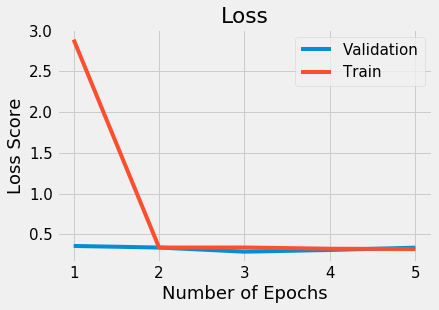

In [50]:
# plot loss vs epoch for train and test
epoch = [1,2,3,4,5]
plt.plot(epoch, loss_val, label = 'Validation')
plt.plot(epoch, loss_train, label = 'Train')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Score')
plt.title('Loss')
plt.legend()

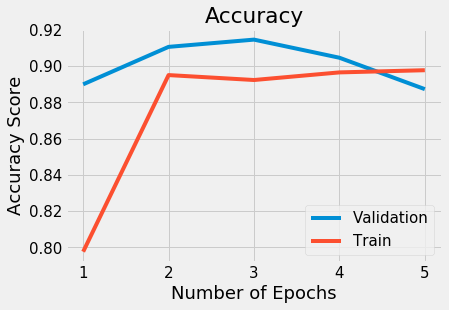

In [51]:
# plot accuracy vs epoch for train and test
plt.plot(epoch, acc_val, label = 'Validation')
plt.plot(epoch, acc_train, label = 'Train')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Score')
plt.title('Accuracy')
plt.legend()